# My Opinion on SQL

SQL is an integral part of Data Science, to prove my point, here are some facts:

1. SQL is one of the most tested and proven languages in use, having been used in databases for over 40 years.

2. SQL, being a declarative language, lets the user focus on the end goal without having to worry about the process

3. According to Star Trek Discovery, SQL will still be in use in the 23rd century (and Starfleet engineers will forget to protect systems against SQL injection attacks).

# Introduction

This project aims to analyze CIA Factbook Data, a compendium of statistics about all of the countries on Earth.

According to the CIA [website](https://www.cia.gov/library/publications/the-world-factbook/index.html) the World Factbook provides information on the history, people and society, government, economy, energy, geography, communications, transportation, military, and transnational issues for 267 world entities.

We will be working with the compressed version of the database which can be accesed [here](https://dsserver-prod-resources-1.s3.amazonaws.com/257/factbook.db)

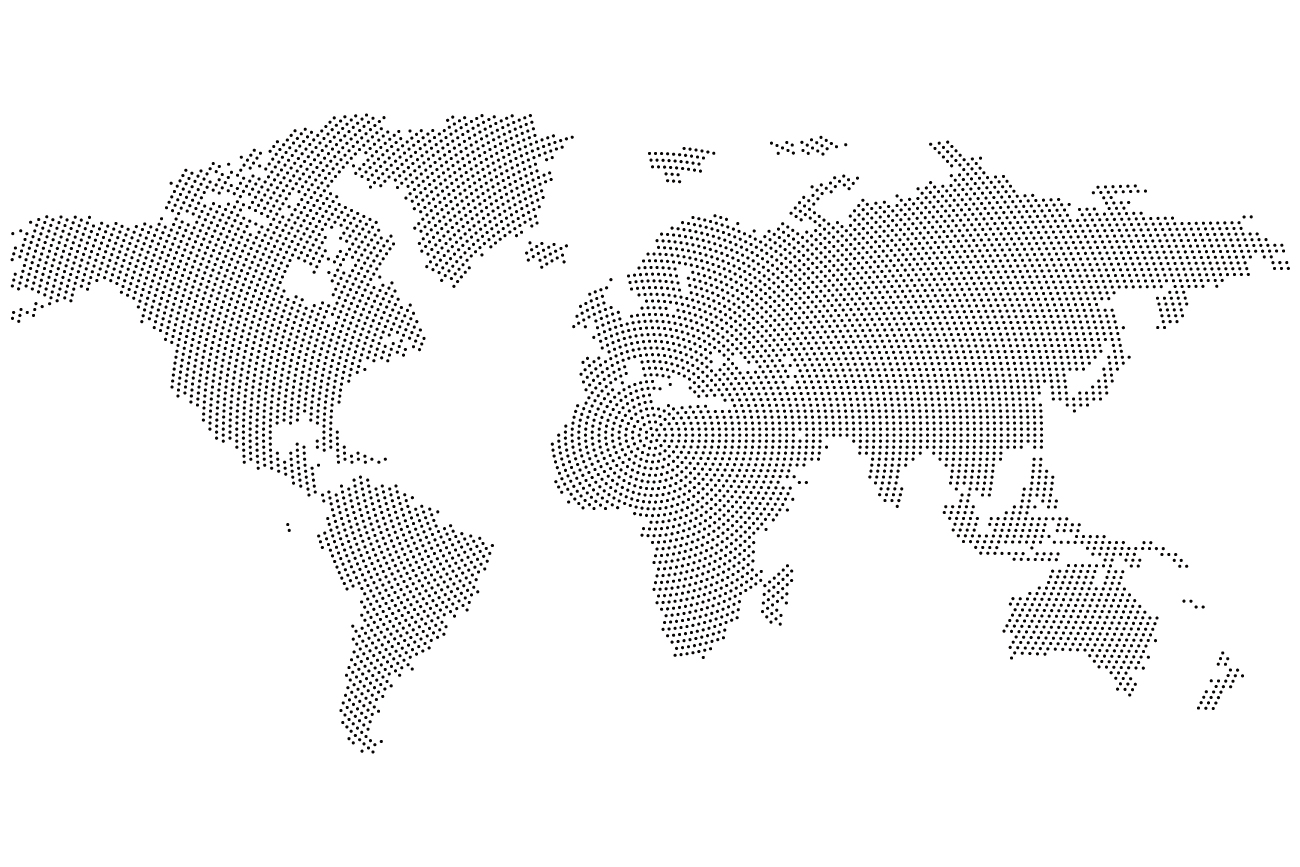

# Objective

The objective of the project is just to write some SQL queries to extract some interesting information from the CIA Factbook about the countries on Earth.

Setting up the Environment - Its time for Action!!

In [1]:
%%capture
%load_ext sql
%sql sqlite:///factbook.db

Now let's take a look into the tables inside the database

In [2]:
%%sql
SELECT *
  FROM sqlite_master
 WHERE type='table';

 * sqlite:///factbook.db
Done.


type,name,tbl_name,rootpage,sql
table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, ""code"" varchar(255) NOT NULL, ""name"" varchar(255) NOT NULL, ""area"" integer, ""area_land"" integer, ""area_water"" integer, ""population"" integer, ""population_growth"" float, ""birth_rate"" float, ""death_rate"" float, ""migration_rate"" float)"



The database has only one table called "facts" which we'll be using for our entire project. Now let's quickly check the first 5 rows!

In [3]:
%%sql
SELECT * FROM facts
LIMIT 5;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


# Summary Statistics

Let's quickly calculate the statistics for max & min population and highest and lowest population growth ratio

In [4]:
%%sql
SELECT
MAX(population) max_pop,
MIN(population) min_pop,
MAX(population_growth) max_pop_growth,
MIN(population_growth) min_pop_growth
FROM facts;

 * sqlite:///factbook.db
Done.


max_pop,min_pop,max_pop_growth,min_pop_growth
7256490011,0,4.02,0.0


# Outliers

It seems like there is a country with 0 population and another with more than 7.2 billion people. Let's find out which ones are those?

In [5]:
%%sql
SELECT *
  FROM facts
 WHERE population == (SELECT MIN(population)
                        FROM facts
                     );

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
250,ay,Antarctica,None,280000,None,0,None,None,None,None


It is evident that table contains a row of Antarctica which has 0 population.

In [6]:
%%sql
SELECT *
  FROM facts
 WHERE population == (SELECT MAX(population)
                        FROM facts
                     );

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


We can see that table contains the row  whole "World" which has the population of 7.2 billion.

Yayyyy! I figured out the outlier :)

We should recalcualte the summary statistics again by excluding the row whole world now.

In [9]:
#Revisited Summary Statistics
%%sql
SELECT MIN(population) AS min_pop,
       MAX(population) AS max_pop,
       MIN(population_growth) AS min_pop_growth,
       MAX(population_growth) AS max_pop_growth 
  FROM facts
 WHERE name <> 'World';

 * sqlite:///factbook.db
Done.


min_pop,max_pop,min_pop_growth,max_pop_growth
0,1367485388,0.0,4.02


There's a country whose population is close to 1.4 billion. We got it.

Now let's explore the average values for population and area

In [10]:
%%sql
SELECT AVG(population) AS avg_pop,
       AVG(area) AS avg_area
  FROM facts
 WHERE name <> 'World';

 * sqlite:///factbook.db
Done.


avg_pop,avg_area
32242666.56846473,555093.546184739


We see that the average population is around 32 million and the average area is 555 thousand square kilometers.

#Identifying densely populated countries
We'll now find the countries that have:
* Above average values for population
* below average values for area


In [12]:
#I am good at writing subqueries dynamically
%%sql
SELECT *
  FROM facts
 WHERE population >(SELECT AVG(population) 
                      FROM facts
                   )
                   
AND (SELECT AVG(area)
       FROM facts
    );
    

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
14,bg,Bangladesh,148460,130170,18290,168957745,1.6,21.14,5.61,0.46
24,br,Brazil,8515770,8358140,157630,204259812,0.77,14.46,6.58,0.14
37,ch,China,9596960,9326410,270550,1367485388,0.45,12.49,7.53,0.44
40,cg,"Congo, Democratic Republic of the",2344858,2267048,77810,79375136,2.45,34.88,10.07,0.27
53,eg,Egypt,1001450,995450,6000,88487396,1.79,22.9,4.77,0.19
58,et,Ethiopia,1104300,None,104300,99465819,2.89,37.27,8.19,0.22
61,fr,France,643801,640427,3374,66553766,0.43,12.38,9.16,1.09
65,gm,Germany,357022,348672,8350,80854408,0.17,8.47,11.42,1.24
77,in,India,3287263,2973193,314070,1251695584,1.22,19.55,7.32,0.04
78,id,Indonesia,1904569,1811569,93000,255993674,0.92,16.72,6.37,1.16


Some of these countries are generally known to be densely populated, so we have confidence in our results!

Now! You might be wondering what's next? We stil have some exicting steps to explore from this data.  What are those?

1 What country has the most people? What country has the highest growth rate?

2 Which countries have the highest ratios of water to land? Which countries have more       water than land?

3 Which countries will add the most people to their population next year?

4 Which countries have a higher death rate than birth rate?

5 What countries have the highest population/area ratio and how does it compare to list we   found in the previous screen?


# Further Analysis

We'll start exploring each point by point not in a chronological order. Let's begin with highest population/area ratio and how does it compare to list we found in the previous screen?

Before we begin this, the table has a rows of 'World' & 'Antarctica' which are outliers.
These rows might lead us to some mistakes, for example, if we calculated the average population, the world's population of over 7 billion people and the Antartic's population of 0 would make us have wrong results. That is why we'll delete these rows.
Please refer to Code block 5 & 6 for better understanding of this outlier.

In [26]:
%%sql
DELETE FROM facts
WHERE id = 261

 * sqlite:///factbook.db
0 rows affected.


[]

In [19]:
%%sql
DELETE FROM facts
WHERE id = 250

 * sqlite:///factbook.db
0 rows affected.


[]

In [27]:
#After removing the both rows from the table
%%sql
SELECT *
  FROM facts;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46
6,ac,Antigua and Barbuda,442,442,0,92436,1.24,15.85,5.69,2.21
7,ar,Argentina,2780400,2736690,43710,43431886,0.93,16.64,7.33,0.0
8,am,Armenia,29743,28203,1540,3056382,0.15,13.61,9.34,5.8
9,as,Australia,7741220,7682300,58920,22751014,1.07,12.15,7.14,5.65
10,au,Austria,83871,82445,1426,8665550,0.55,9.41,9.42,5.56


In [46]:
%%sql
SELECT *
  FROM facts
 WHERE population >(SELECT AVG(population) 
                      FROM facts
                   )
                   
AND (SELECT AVG(area)
       FROM facts
    );

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
7,ar,Argentina,2780400,2736690,43710,43431886,0.93,16.64,7.33,0.0
14,bg,Bangladesh,148460,130170,18290,168957745,1.6,21.14,5.61,0.46
24,br,Brazil,8515770,8358140,157630,204259812,0.77,14.46,6.58,0.14
28,bm,Burma,676578,653508,23070,56320206,1.01,18.39,7.96,0.28
32,ca,Canada,9984670,9093507,891163,35099836,0.75,10.28,8.42,5.66
37,ch,China,9596960,9326410,270550,1367485388,0.45,12.49,7.53,0.44
38,co,Colombia,1138910,1038700,100210,46736728,1.04,16.47,5.4,0.64
40,cg,"Congo, Democratic Republic of the",2344858,2267048,77810,79375136,2.45,34.88,10.07,0.27


We have a difference between the list comparatively what we have acheived earlier in the code block -12 that are densely populated. This is what we want finally!

In [37]:
%%sql
SELECT *, MAX(population) FROM facts;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,MAX(population)
37,ch,China,9596960,9326410,270550,1367485388,0.45,12.49,7.53,0.44,1367485388


In [39]:
%%sql
SELECT *, MIN(population) FROM facts;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,MIN(population)
238,pc,Pitcairn Islands,47,47,0,48,0.0,None,None,None,48


In [40]:
%%sql
SELECT *, MAX(population_growth) FROM facts;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,MAX(population_growth)
162,od,South Sudan,644329,None,None,12042910,4.02,36.91,8.18,11.47,4.02


Now let's see the countries with highest ratios of water to land?

In [42]:
%%sql
SELECT COUNT(*)
  FROM facts
 WHERE area_water > area_land

 * sqlite:///factbook.db
Done.


COUNT(*)
2


Only two of the countries will do!

We'll now see which countries have more water than land?

In [56]:
%%sql
SELECT name,
       CAST(area_water AS FLOAT) / CAST(area AS FLOAT) ratio
  FROM facts
 ORDER BY ratio DESC
 LIMIT 10;

 * sqlite:///factbook.db
Done.


name,ratio
British Indian Ocean Territory,0.9988970588235294
Virgin Islands,0.818848167539267
Puerto Rico,0.35682691610470596
"Bahamas, The",0.2788184438040346
Guinea-Bissau,0.2215916955017301
Malawi,0.20596873839505755
Netherlands,0.1841465469513516
Uganda,0.18228661040997685
Eritrea,0.141156462585034
Liberia,0.13512736937567904


We can see British Indian Ocean Terittory and Virgin Islands have more water than land. Two countries as expected!

We'll continue to see the highest and lowest birth rates

In [47]:
%%sql
SELECT name,
       birth_rate
  FROM facts
ORDER BY birth_rate DESC
LIMIT 10;

 * sqlite:///factbook.db
Done.


name,birth_rate
Niger,45.45
Mali,44.99
Uganda,43.79
Zambia,42.13
Burkina Faso,42.03
Burundi,42.01
Malawi,41.56
Somalia,40.45
Angola,38.78
Mozambique,38.58


It's interesting to know that all top ten countries with highest birth rates belongs to Africa.

We can observe from our table that some coutries do not have birth_data information, in order to identify the lowest birth rates we'll write a query and  filter the birth_rates greater than 0

In [50]:
%%sql
SELECT name,
       birth_rate
  FROM facts
 WHERE birth_rate > 0
 ORDER BY  birth_rate 
 LIMIT 10;

 * sqlite:///factbook.db
Done.


name,birth_rate
Monaco,6.65
Saint Pierre and Miquelon,7.42
Japan,7.93
Andorra,8.13
"Korea, South",8.19
Singapore,8.27
Slovenia,8.42
Germany,8.47
Taiwan,8.47
San Marino,8.63


Most of these countries belongs to Europe & Asia. Let's see the countries with highest and lowest death rates

In [52]:
%%sql
SELECT name,
       death_rate
  FROM facts
ORDER BY death_rate DESC
LIMIT 10

 * sqlite:///factbook.db
Done.


name,death_rate
Lesotho,14.89
Ukraine,14.46
Bulgaria,14.44
Guinea-Bissau,14.33
Latvia,14.31
Chad,14.28
Lithuania,14.27
Namibia,13.91
Afghanistan,13.89
Central African Republic,13.8


Most of these countries belongs to Europe,Asian & African countries. Now let's quickly check the highest death_rates also by filtering the ones with greater than 0

In [53]:
%%sql
SELECT name,
       death_rate
  FROM facts
 WHERE death_rate > 0
 ORDER BY death_rate
 LIMIT 10;

 * sqlite:///factbook.db
Done.


name,death_rate
Qatar,1.53
United Arab Emirates,1.97
Kuwait,2.18
Bahrain,2.69
Gaza Strip,3.04
Turks and Caicos Islands,3.1
Saudi Arabia,3.33
Oman,3.36
Singapore,3.43
West Bank,3.5


All thse countries belongs to Asia, except for the country Turks and Caicos Islands which is placed in North America as per my google search :)

Finally we'll now calculate the countries with highest death_rates than birth_rates

In [57]:
%%sql
SELECT name,
       CAST(birth_rate AS FLOAT) - CAST(death_rate AS FLOAT) birth_death_diff
  FROM facts
 WHERE birth_death_diff > 0
 ORDER BY birth_death_diff DESC

 * sqlite:///factbook.db
Done.


name,birth_death_diff
Malawi,33.150000000000006
Uganda,33.1
Niger,33.03
Burundi,32.739999999999995
Mali,32.1
Burkina Faso,30.310000000000002
Zambia,29.46
Ethiopia,29.080000000000005
South Sudan,28.729999999999997
Tanzania,28.39


By looking at the top 10 results, we have highest deat_rates in african countries.